In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

나이브 베이즈(Naive Bayes)

확률 기반 머신러닝 분류 알고리즘으로 데이터를 나이브(단순)하고 독립적인 사건으로 가정하고 이 독립 사건들을 베이즈 이론에 대입시켜 가장 높은 확률의 레이블로 분류하는 알고리즘이다.  
https://ineed-coffee.github.io/posts/Naive-Bayesian/ 참조

가우시안 나이브 베이즈(Gaussian Naive Bayes)  
분류 특징들의 값이 정규(가우시안) 분포되어 있다는 가정하에 조건부 확률을 계산하며 연속적인 성질이 있는 특성 데이터를 분류하는데 적합하다.

P(A): 어떤 사건 A가 발생할 확률  
P(B): 어떤 사건 B가 발생할 확률  
P(A|B): 어떤 사건 B가 발생했을 때 사건 A가 발생할 확률  
P(B|A): 어떤 사건 A가 발생했을 때 사건 B가 발생할 확률  

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

<img src="./naivebayes1.png" align="left" width="1500"/>

<img src="./naivebayes2.png" align="left" width="1500"/>

<img src="./naivebayes3.png" align="left" width="1600"/>

가우시안 나이브 베이즈를 활용한 붓꽃(iris) 분류

사이킷런이 제공하는 iris 데이터를 활용해 데이터의 특징에 따른 붓꽃의 종류를 구분한다.

In [2]:
# 사이킷런이 제공하는 iris 데이터를 불러오기 위해 import 한다.
from sklearn.datasets import load_iris

데이터 획득  
사이킷런에서 제공하는 iris 데이터 셋을 사용한다.

In [3]:
dataset = load_iris() # 사이킷런이 제공하는 iris 데이터 셋을 불러온다.
# print(type(dataset))
# print(dataset)
# print(dataset.data) # 사이킷런이 제공하는 데이터 셋에서 데이터(피쳐)만 얻어온다.
# 'sepal length (cm)': 꽃받침 길이, 'sepal width (cm)': 꽃받침 너비, 'petal length (cm)': 꽃잎 길이, 'petal width (cm)': 꽃잎 너비
# print(dataset.feature_names) # 사이킷런이 제공하는 데이터 셋에서 피쳐 이름만 얻어온다.
# print(dataset.target) # 사이킷런이 제공하는 데이터 셋에서 결과(레이블)만 얻어온다.
# 'setosa': 0, 'versicolor': 1, 'virginica': 2
# print(dataset.target_names) # 사이킷런이 제공하는 데이터 셋에서 레이블 이름만 얻어온다.
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
# df['target1'] = dataset.target
'''
df['target2'] = np.NaN
df.loc[df.target1 == 0, 'target2'] = 'setosa'
df.loc[df.target1 == 1, 'target2'] = 'versicolor'
df.loc[df.target1 == 2, 'target2'] = 'virginica'
'''
# df['target2'] = df.target1.map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
df['target'] = pd.Series(dataset.target).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
# df.to_csv('./data/iris_df.csv')
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


데이터 시각화

In [4]:
setosa_df = df[df.target =='setosa']
versicolor_df = df[df.target =='versicolor']
virginica_df = df[df.target =='virginica']

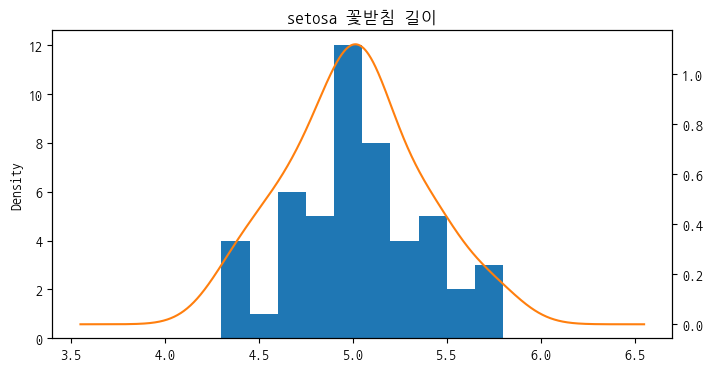

In [5]:
# plt.figure(figsize=(8, 6))
setosa_df['sepal length (cm)'].plot(kind='hist')
setosa_df['sepal length (cm)'].plot(kind='kde', secondary_y=True, figsize=(8, 4), title='setosa 꽃받침 길이')
plt.show()

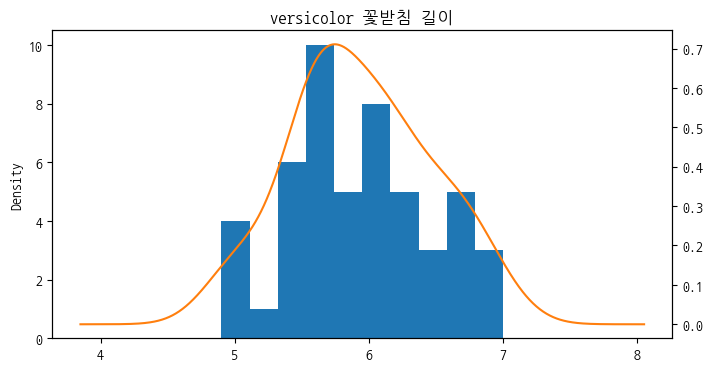

In [6]:
versicolor_df['sepal length (cm)'].plot(kind='hist')
versicolor_df['sepal length (cm)'].plot(kind='kde', secondary_y=True, figsize=(8, 4), title='versicolor 꽃받침 길이')
plt.show()

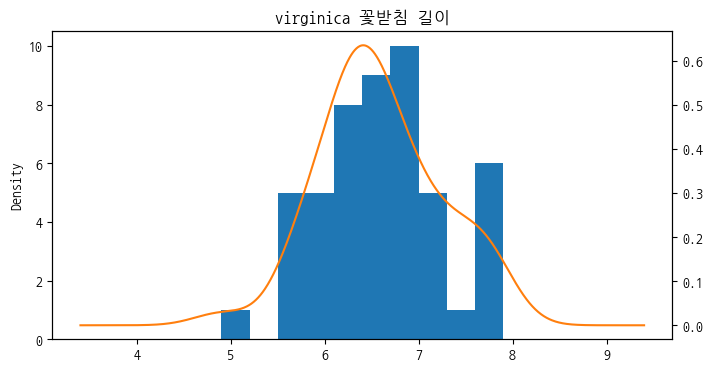

In [7]:
virginica_df['sepal length (cm)'].plot(kind='hist')
virginica_df['sepal length (cm)'].plot(kind='kde', secondary_y=True, figsize=(8, 4), title='virginica 꽃받침 길이')
plt.show()

데이터 다듬기  
가우시안 나이브 베이즈 모델 학습을 시키기 위해 train 데이터와 test 데이터로 나눈다.

In [8]:
# 피쳐와 레이블이 데이터프레임 1개에 모두 있을 경우 아래와 같이 학습 데이터와 테스트 데이터를 나눈다.
# train, test = train_test_split(데이터프레임, train_size=0.8)
# x_train = train[[피쳐1, 피쳐2, ]]
# y_train = train[레이블]
# x_test = test[[피쳐1, 피쳐2, ]]
# y_test = test[레이블]

# 읽어들인 iris 데이터 셋은 피쳐(dataset.data)와 레이블(dataset.target)이 별도로 존재한다.
# 피쳐와 레이블이 별도로 존재할 경우 아래와 같이 학습 데이터와 테스트 데이터를 나눈다.
# x_train: 학습 데이터의 피쳐, y_train: 학습 데이터의 레이블
# x_test: 테스트 데이터의 피쳐, y_test: 테스트 데이터의 레이블
# x_train, x_test, y_train, y_test = train_test_split(피쳐, 레이블, train_size=0.8)
x_train, x_test, y_train, y_test = train_test_split(dataset.data, dataset.target, train_size=0.8)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(120, 4) (120,) (30, 4) (30,)


가우시안 나이브 베이즈 모델을 만들고 학습시키기

In [9]:
# 가우시안 나이브 베이즈 모델을 사용하기 위해 import 한다.
from sklearn.naive_bayes import GaussianNB

In [10]:
# 가우시안 나이브 베이즈 모델을 만들고 학습시킨다.
# model = GaussianNB() # 가우시안 나이브 베이즈 모델을 만든다.
# model.fit(x_train, y_train) # 가우시안 나이브 베이즈 모델에 학습 데이터를 넘겨서 학습시킨다.
model = GaussianNB().fit(x_train, y_train)

모델 테스트

In [11]:
# predict() 메소드의 인수로 테스트 데이터의 피쳐를 넘겨서 예측값을 계산한다.
predict = model.predict(x_test)
print(predict)
# accuracy_score() 메소드의 인수로 테스트 데이터의 레이블(실제값)과 예측값을 넘겨서 정확도를 계산한다.
accuracy = accuracy_score(y_test, predict)
print('정확도: {:6.2%}'.format(accuracy))

[0 2 2 0 0 1 2 1 2 2 0 1 2 0 2 0 0 0 0 1 1 0 1 0 1 2 2 1 1 0]
정확도: 100.00%


In [12]:
# confusion_matrix() 메소드의 인수로 테스트 데이터의 레이블(실제값)과 예측값을 넘겨서 혼동 행렬을 출력한다.
print(confusion_matrix(y_test, predict))

[[12  0  0]
 [ 0  9  0]
 [ 0  0  9]]


In [13]:
# classification_report() 메소드의 인수로 테스트 데이터의 레이블(실제값)과 예측값을 넘겨서 분류 리포트를 출력한다.
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [14]:
pd.DataFrame({'실제값': y_test, '예측값': predict})

,실제값,예측값
0,0,0
1,2,2
2,2,2
3,0,0
4,0,0
5,1,1
6,2,2
7,1,1
8,2,2
9,2,2
